# Estimation of tree height using GEDI dataset - Random Forest prediction


In order to run this notebook, please do what follows:

    cd  /media/sf_LVM_shared/my_SE_data/exercise
    source $HOME/venv/bin/activate
    pip3 install pyspatialml
    jupyter lab Tree_Height_03RF_pred

Find a relationship between tree height and enviromental predictors to be able to predict out side the GEDI observation.  
The model, in its simplest form, looks like the following:  

```
y ~ f ( a*x1 + b*x2 + c*x3 + …)  + ε,  

```
    
where y is a response variable, the x's are predictor variables, and ε is the associated error.

**There are many different types of models**

* Parametric models – make assumptions about the underlying distribution of the data.
    * Maximum likelihood classification
    * Discriminant analysis
    * General linear models (ex. linear regression)


* Nonparametric models – make no assumptions about the underlying data distributions.
    * Generalized additive models
    * Support Vector Machine
    * Artificial neural networks
    * Random Forest

## Random forest

Random forest is a Supervised Machine Learning Algorithm that is used widely in **Classification** (containing categorical variables) and **Regression** (response continuous variables) problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.  

One of the most important features of the Random Forest Algorithm is that it can handle continuous and categorical variables predictors without any assamption on their data distribution, dimension, and even if the predictors are autocorrelated.

**Bagging**  
Bagging, also known as Bootstrap Aggregation is the ensemble technique used by random forest. Choosesing a random sample from the data set it is creating a tree. Each tree is generated from the samples (Bootstrap Samples) provided by the Original Data with replacement known as row sampling. This step of row sampling with replacement is called bootstrap.
Each is trained independently which generates results. The final output is based on majority voting after combining the results of all models. This step which involves combining all the results and generating output based on majority voting is known as tree aggregation.


**Steps involved in random forest algorithm:**  

* Step 1: In Random forest n number of random records are taken from the data set having k number of records.  

* Step 2: Individual decision trees are constructed for each sample.  

* Step 3: Each decision tree will generate an output.  
* Step 4: Final output is considered based on Majority Voting or Averaging for Classification and regression respectively.  
 
(source https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/)

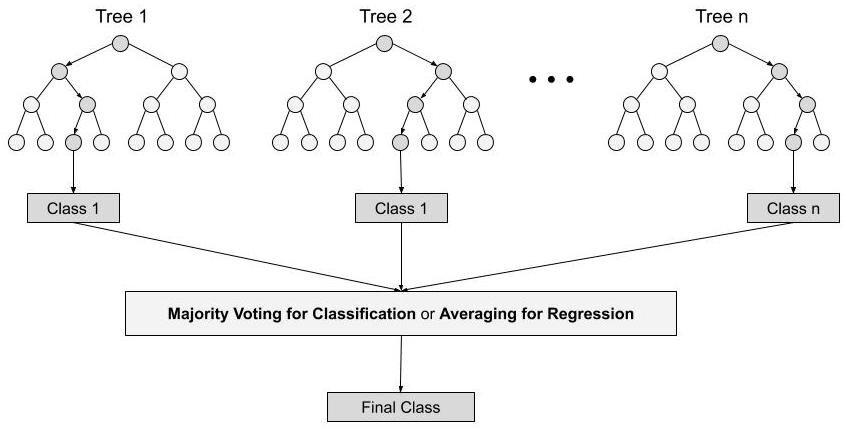

In [3]:
from IPython.display import Image
Image("../images/Random_Forest.jpg" , width = 700, height = 700)

**Random Forest exercise**   
In this exercise we will use Random Forest Regression algorithm with the [sklearn](https://scikit-learn.org/stable/) python package to estimage the tree height. In last step, we are going to use the [Pyspatialml](https://pyspatialml.readthedocs.io/en/latest/index.html) for the spatial prediction on the raster files.

In [5]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
#from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6.5)

## Import raw data, extracted predictors and show the data distribution

In [6]:
predictors = pd.read_csv("tree_height/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


In [7]:
len(predictors)

1267239

Plotting the data 

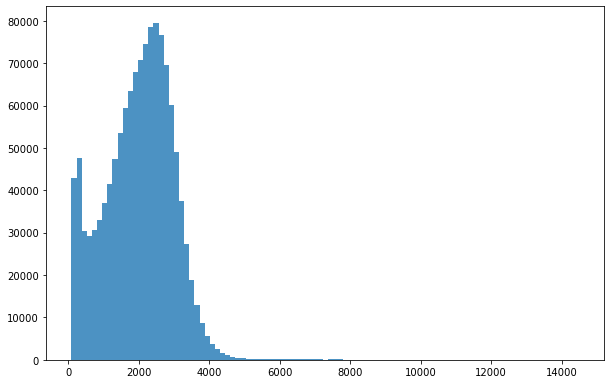

In [8]:
bins = np.linspace(min(predictors['h']),max(predictors['h']),100)
plt.hist((predictors['h']),bins,alpha=0.8);

Select only tree with height less then 70m (highest tree in germany 67m https://visit.freiburg.de/en/attractions/waldtraut-germany-s-tallest-tree)

In [9]:
predictors_sel = predictors.loc[(predictors['h'] < 7000)  ].sample(100000)
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 ) # add a culumn of heigh in meter
len(predictors_sel)
predictors_sel.head(10)

,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
370092,370093,7.148672,48.558254,3925.00,39.2500,1438,14,3071,6062,-27.969378,-358378592,1.330265,0.274882,572.038086,14,305.688965,241.041260,-81.518555,-0.142304,25,908108,20.714588,460.543823,78
1251561,1251562,9.866513,49.716534,730.75,7.3075,1539,14,2140,6427,8.613005,29920092,1.361732,-0.039743,343.073090,26,231.686035,31.629883,257.204590,-0.004678,10,810953,16.347046,462.243103,87
643323,643324,7.868923,49.916156,1342.00,13.4200,1513,15,1769,6366,11.696195,-120765048,0.883955,0.021111,247.184982,19,-161.737305,-86.626953,76.494873,0.005264,9,547318,18.506214,475.317993,64
737250,737251,8.352336,48.825527,3119.75,31.1975,1514,14,3160,6582,-11.774264,-341909536,-0.335858,-0.102649,267.600372,13,898.128418,372.691406,529.572021,-0.086359,14,762537,21.722124,490.426422,85
372417,372418,7.153930,49.935268,1696.00,16.9600,1522,13,1922,5999,-36.624672,-194525472,1.145734,0.032831,427.121490,24,-83.100098,-113.073730,-39.359375,-0.027596,12,587541,18.439182,442.586365,82
105119,105120,6.419861,49.263805,2060.00,20.6000,1551,13,2209,6088,-36.131744,-300403520,1.911310,0.058681,297.526733,24,147.807617,11.698242,307.726318,-0.024495,9,785320,18.404999,465.559814,98
543224,543225,7.589230,49.877533,187.75,1.8775,1479,13,2145,5986,-3.757046,-65064452,1.265881,0.002465,455.967377,21,-82.714844,-117.704590,50.568359,-0.050714,18,582821,19.171392,441.713867,89
855520,855521,8.727403,49.316618,2523.50,25.2350,1507,17,2407,6504,14.034105,-266940064,-1.076780,0.070526,206.799576,18,68.510254,101.197021,323.254395,0.028773,7,705218,21.709143,550.755737,45
557122,557123,7.629687,49.681153,2252.00,22.5200,1519,14,1705,6455,2.980086,-291743360,-1.499598,0.060641,199.863480,20,-147.037109,-123.435059,-137.032227,-0.330101,14,595952,21.505602,502.902374,83
342400,342401,7.084576,49.744400,3683.00,36.8300,1355,13,2339,5743,33.109131,-116536064,2.309944,0.104253,586.376953,26,89.297119,72.667725,-67.999023,0.184217,27,656705,21.482201,420.090607,89


Plotting response variables distribution

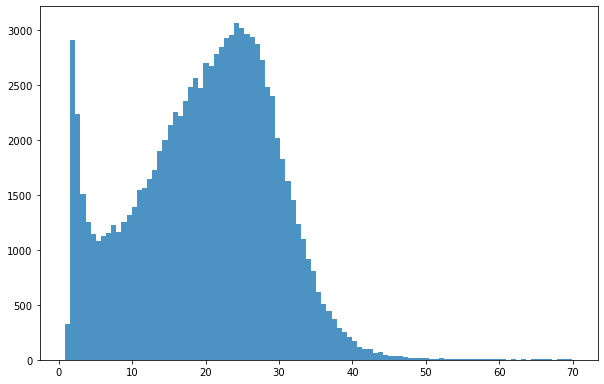

In [10]:
bins = np.linspace(min(predictors_sel['hm']),max(predictors_sel['hm']),100)
plt.hist((predictors_sel['hm']),bins,alpha=0.8);

The Global Forest Canopy Height, 2019 map has been release in 2020 (scientific publication https://doi.org/10.1016/j.rse.2020.112165). The authors use a regression tree model that was calibrated and applied to each individual Landsat GLAD ARD tile (1 × 1◦) in a “moving window” mode. Such tree height estimation is storede in forestheight.tiff and in the table as forestheight column. 
A correlation plot and its pearson coefficient is show below.

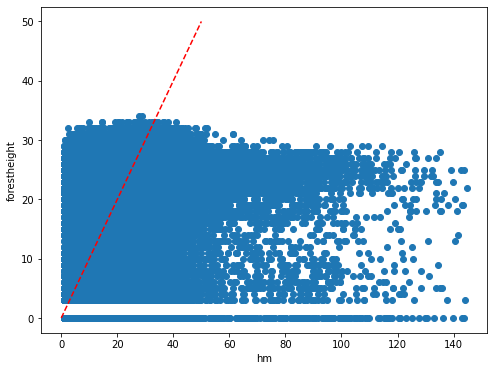

In [11]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(predictors['h']/100,predictors['forestheight'])
plt.xlabel('hm')
plt.ylabel('forestheight')
ident = [0, 50]
plt.plot(ident,ident,'r--')


In [12]:
pearsonr_Publication_Estimation = pearsonr(predictors['h'],predictors['forestheight'])[0]
pearsonr_Publication_Estimation

0.4527925129990055

We will try to beats such error estimation using a more advance ML tecnques and different enviromental predictors that better express the ecological condition.

## Data set splitting
Split the dataset (predictors_sel) in order to create response variable vs predictors variables (we are excluding forestheight predictors).

In [13]:
   X = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].values
Y = predictors_sel.iloc[:,4:5].values
feat = predictors_sel.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23]].columns.values

Double ceck that we select the right columns

In [14]:
feat

array(['BLDFIE_WeigAver', 'CECSOL_WeigAver', 'CHELSA_bio18',
       'CHELSA_bio4', 'convergence', 'cti', 'devmagnitude', 'eastness',
       'elev', 'glad_ard_SVVI_max', 'glad_ard_SVVI_med',
       'glad_ard_SVVI_min', 'northness', 'ORCDRC_WeigAver',
       'outlet_dist_dw_basin', 'SBIO3_Isothermality_5_15cm',
       'SBIO4_Temperature_Seasonality_5_15cm', 'treecover'], dtype=object)

In [15]:
Y.shape

(100000, 1)

In [16]:
X.shape

(100000, 18)

Create 4 dataset for training and testing the algorithm 

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

## Random Forest default parameters

Random Forest can be implemented using the [RandomForestRegressor in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Training Random Forest using default parameters

In [18]:
rf = RandomForestRegressor(random_state = 42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [19]:
rfReg = RandomForestRegressor(min_samples_leaf=50, oob_score=True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
pearsonr_all = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all

[0.5981338829006941, 0.5148900957802557]

In [20]:
# checking the oob score
rfReg.oob_score_

0.2545346304092476

Additional resources how to reduce the oob error can found at  
https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

### Random Forest tuning


* "max_features": number of features to consider when looking for the best split. 
* "max_samples": number of samples to draw from X to train each base estimator.
* "n_estimators": identify the number of trees that must grow. It must be large enough so that the error is stabilized. Defoult 100.
* "max_depth": max number of levels in each decision tree.

Using this pseudo code tune the parameters in order the improve the algoirithm performance


    pipeline = Pipeline([('rf',RandomForestRegressor())])

    parameters = {
            'rf__max_features':(3,4,5),
            'rf__max_samples':(0.5,0.6,0.7),
            'rf__n_estimators':(500,1000),
            'rf__max_depth':(50,100,200,300)}

    grid_search = GridSearchCV(pipeline,parameters,n_jobs=6,cv=5,scoring='r2',verbose=1)
    grid_search.fit(X_train,y_train)
    

    rfReg = RandomForestRegressor(n_estimators=5000,max_features=0.33,max_depth=500,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score = True) 
    rfReg.fit(X_train, y_train); 
    dic_pred = {} 
    dic_pred['train'] = rfReg.predict(X_train) 
    dic_pred['test'] = rfReg.predict(X_test) 
    pearsonr_all_tune = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]] 
    pearsonr_all_tune

    grid_search.best_score_

    print ('Best Training score: %0.3f' % grid_search.best_score_) 
    print ('Optimal parameters:') best_par = grid_search.best_estimator_.get_params() 
    for par_name in sorted(parameters.keys()): 
        print ('\t%s: %r' % (par_name, best_par[par_name]))
        
Tracking the error rate trend as in https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

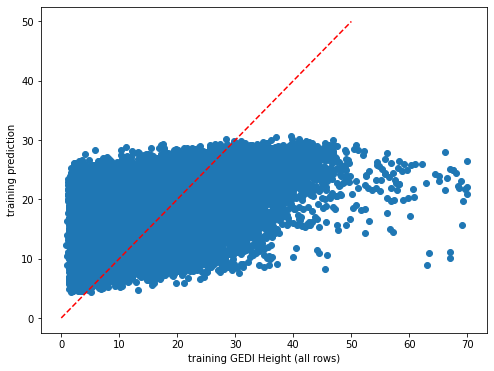

In [21]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('training GEDI Height (all rows)')
plt.ylabel('training prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

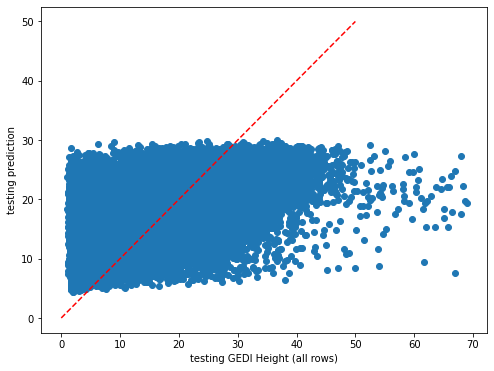

In [22]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('testing GEDI Height (all rows)')
plt.ylabel('testing prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [23]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [24]:
ind

array([ 1, 13,  0,  6,  8,  2,  4, 16,  5, 15,  3, 12, 11,  9,  7, 14, 10,
       17])

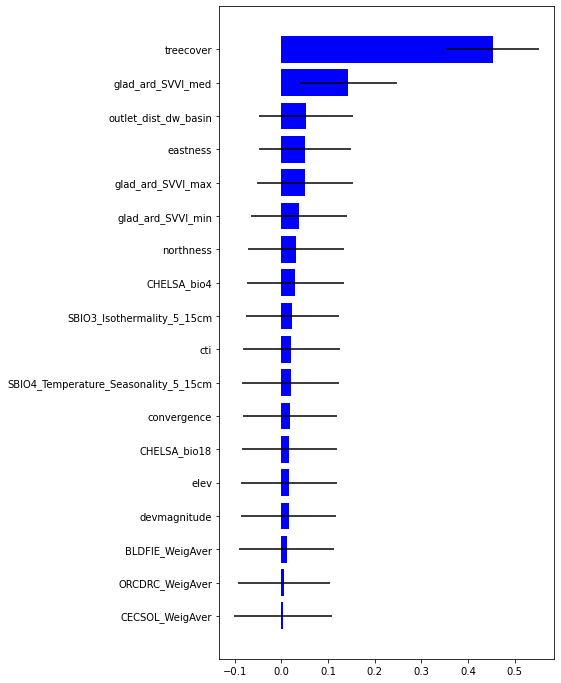

In [25]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

Most important variable is treecover followed by Spectral Variability Vegetation Index, followed by outlet_dist_dw_basin that is a proxy of water accumulation. Besides eastness and northness describes microclimat condition.

## Base on data quality flag select more reilable tree height.

**File storing tree hight (cm) obtained by 6 algorithms, with their associate quality flags.**
The quality flags can be used to refine and select the best tree height estimation and use it as tree height observation.

* a?_95: tree hight (cm) at 95 quintile, for each algorithm  
* min_rh_95: minimum value of tree hight (cm) ammong the 6 algorithms  
* max_rh_95: maximum value of tree hight (cm) ammong the 6 algorithms  
* BEAM: 1-4 coverage beam = lower power (worse) ; 5-8 power beam = higher power (better)  
* digital_elev: digital mdoel elevation  
* elev_low: elevation of center of lowest mode  
* qc_a?: quality_flag for six algorithms quality_flag = 1 (better); = 0 (worse)  
* se_a?: sensitivity for six algorithms sensitivity < 0.95 (worse);  sensitivity > 0.95  (beter )  
* deg_fg: (degrade_flag) not-degraded 0 (better) ;  degraded > 0 (worse)  
* solar_ele: solar elevation. > 0 day (worse); < 0 night (better)  

In [26]:
height_6algorithms = pd.read_csv("tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
height_6algorithms.head(6)

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
0,1,6.050001,49.727499,3139,3139,3139,3120,3139,3139,3120,3139,5,410.0,383.72153,1,1,1,1,1,1,0.962,0.984,0.968,0.962,0.989,0.979,0,17.7
1,2,6.050002,49.922155,1022,2303,970,872,5596,1524,872,5596,5,290.0,2374.14110,0,0,0,0,0,0,0.948,0.990,0.960,0.948,0.994,0.980,0,43.7
2,3,6.050002,48.602377,380,1336,332,362,1336,1340,332,1340,4,440.0,435.97781,1,1,1,1,1,1,0.947,0.975,0.956,0.947,0.981,0.968,0,0.2
3,4,6.050009,48.151979,3153,3142,3142,3127,3138,3142,3127,3153,2,450.0,422.00537,1,1,1,1,1,1,0.930,0.970,0.943,0.930,0.978,0.962,0,-14.2
4,5,6.050010,49.588410,666,4221,651,33,5611,2723,33,5611,8,370.0,2413.74830,0,0,0,0,0,0,0.941,0.983,0.946,0.941,0.992,0.969,0,22.1
5,6,6.050014,48.608456,787,1179,1187,761,1833,1833,761,1833,3,420.0,415.51581,1,1,1,1,1,1,0.952,0.979,0.961,0.952,0.986,0.975,0,0.2


In [27]:
height_6algorithms_sel = height_6algorithms.loc[(height_6algorithms['BEAM'] > 4) 
                                            &   (height_6algorithms['qc_a1'] == 1)
                                            &   (height_6algorithms['qc_a2'] == 1)
                                            &   (height_6algorithms['qc_a3'] == 1)    
                                            &   (height_6algorithms['qc_a4'] == 1)    
                                            &   (height_6algorithms['qc_a5'] == 1)    
                                            &   (height_6algorithms['qc_a6'] == 1)
                                            &   (height_6algorithms['se_a1'] > 0.95)    
                                            &   (height_6algorithms['se_a2'] > 0.95)
                                            &   (height_6algorithms['se_a3'] > 0.95)
                                            &   (height_6algorithms['se_a4'] > 0.95)
                                            &   (height_6algorithms['se_a5'] > 0.95)   
                                            &   (height_6algorithms['se_a6'] > 0.95)
                                            &   (height_6algorithms['deg_fg'] == 0)  
                                            &   (height_6algorithms['solar_ele'] < 0)]

In [28]:
height_6algorithms_sel

,ID,X,Y,a1_95,a2_95,a3_95,a4_95,a5_95,a6_95,min_rh_95,max_rh_95,BEAM,digital_elev,elev_low,qc_a1,qc_a2,qc_a3,qc_a4,qc_a5,qc_a6,se_a1,se_a2,se_a3,se_a4,se_a5,se_a6,deg_fg,solar_ele
7,8,6.050019,49.921613,3303,3288,3296,3236,3857,3292,3236,3857,7,320.0,297.68533,1,1,1,1,1,1,0.971,0.988,0.976,0.971,0.992,0.984,0,-33.9
11,12,6.050039,47.995344,2762,2736,2740,2747,3893,2736,2736,3893,5,390.0,368.55121,1,1,1,1,1,1,0.975,0.990,0.979,0.975,0.994,0.987,0,-37.3
14,15,6.050046,49.865317,1398,2505,2509,1316,2848,2505,1316,2848,6,340.0,330.40564,1,1,1,1,1,1,0.973,0.990,0.979,0.973,0.994,0.986,0,-18.2
15,16,6.050048,49.050020,984,943,947,958,2617,947,943,2617,6,300.0,291.22598,1,1,1,1,1,1,0.978,0.991,0.982,0.978,0.995,0.988,0,-35.4
16,17,6.050049,48.391359,3362,3332,3336,3351,4467,3336,3332,4467,5,530.0,504.78122,1,1,1,1,1,1,0.973,0.988,0.977,0.973,0.992,0.984,0,-5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267207,1267208,9.949829,49.216272,2160,2816,2816,2104,3299,2816,2104,3299,8,420.0,386.44556,1,1,1,1,1,1,0.980,0.993,0.984,0.980,0.995,0.989,0,-16.9
1267211,1267212,9.949856,49.881190,3190,3179,3179,3171,3822,3179,3171,3822,6,380.0,363.69348,1,1,1,1,1,1,0.968,0.986,0.974,0.968,0.990,0.982,0,-35.1
1267216,1267217,9.949880,49.873435,2061,2828,2046,2024,2828,2828,2024,2828,7,380.0,361.06812,1,1,1,1,1,1,0.967,0.988,0.974,0.967,0.993,0.983,0,-35.1
1267227,1267228,9.949958,49.127182,366,2307,1260,355,3531,2719,355,3531,6,500.0,493.52792,1,1,1,1,1,1,0.973,0.989,0.978,0.973,0.993,0.985,0,-36.0


Calculate the mean height excluidng the maximum and minimum values 

In [29]:
height_sel =  pd.DataFrame({'ID' : height_6algorithms_sel['ID'] , 
                            'hm_sel': (height_6algorithms_sel['a1_95'] + height_6algorithms_sel['a2_95'] + height_6algorithms_sel['a3_95'] + height_6algorithms_sel['a4_95'] 
                             + height_6algorithms_sel['a5_95'] + height_6algorithms_sel['a6_95'] - height_6algorithms_sel['min_rh_95'] - height_6algorithms_sel['max_rh_95']) / 400 } )

In [30]:
height_sel

,ID,hm_sel
7,8,32.9475
11,12,27.4625
14,15,22.2925
15,16,9.5900
16,17,33.4625
...,...,...
1267207,1267208,26.5200
1267211,1267212,31.8175
1267216,1267217,24.4075
1267227,1267228,16.6300


Merge the new height with the predictors table, using the ID as Primary Key

In [31]:
predictors_hm_sel = pd.merge( predictors ,  height_sel , left_on='ID' ,  right_on='ID' ,  how='right')

In [32]:
predictors_hm_sel.head(6)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
0,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86,32.9475
1,12,6.050039,47.995344,2746.25,1523,12,2612,6181,3.549103,-71279992,0.507727,-0.021408,322.920227,26,660.006104,92.722168,190.979736,-0.034787,16,784807,20.798000,460.501221,97,27.4625
2,15,6.050046,49.865317,2229.25,1517,13,2191,5901,31.054762,-186807440,-1.375050,-0.126880,291.412537,7,1028.385498,915.806396,841.586182,0.024677,16,766444,19.941267,454.185089,54,22.2925
3,16,6.050048,49.050020,959.00,1526,14,2081,6100,9.933455,-183562672,-0.382834,0.086874,246.288010,24,-12.283691,-58.179199,174.205566,0.094175,10,805730,19.849365,470.946533,78,9.5900
4,17,6.050049,48.391359,3346.25,1489,19,2486,5966,-6.957157,-273522688,2.989759,0.214769,474.409088,24,125.583008,6.154297,128.129150,0.017164,15,950190,21.179420,491.398376,85,33.4625
5,19,6.050053,49.877876,529.00,1531,12,2184,5915,-24.278454,-377335296,0.265329,-0.248356,335.534760,25,593.601074,228.712402,315.298340,-0.127365,17,764713,19.760756,448.580811,96,5.2900


In [33]:
predictors_hm_sel = predictors_hm_sel.loc[(predictors['h'] < 7000) ].sample(100000)

In [34]:
predictors_hm_sel

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover,hm_sel
51026,278617,6.934972,48.306057,3091.00,1515,13,2532,6416,-8.054195,-290397664,-0.409105,-0.132705,381.254120,27,185.807129,231.462891,-81.237671,0.146239,10,964136,19.847805,480.472168,99,30.9100
26405,141567,6.561142,48.230171,171.25,1527,19,2541,6291,-0.949946,-138115664,-0.404352,-0.007360,339.417633,0,1344.271973,76.287842,72.826416,0.027970,6,984455,21.723141,506.949188,95,1.7125
125631,709793,8.174701,48.674449,3316.50,1471,17,3901,6283,-38.065781,-230832768,1.633797,0.080666,535.948914,27,-43.610107,-163.524658,-306.815186,0.010982,19,785352,22.753876,499.832825,89,33.1650
153887,876222,8.782162,48.850271,2501.75,1457,17,2404,6309,6.025486,-227260176,1.225852,0.009855,484.552979,20,-115.408936,-218.997314,-271.307373,0.090864,17,866106,18.794195,457.943848,85,25.0175
139752,792166,8.555018,49.522307,1995.50,1527,14,2254,6626,26.038683,54076864,-1.714810,-0.003345,100.393318,17,544.338867,246.006348,287.403564,0.002302,9,661927,22.180372,547.316223,87,19.9550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57847,311262,7.012238,49.664535,2974.50,1370,10,2461,5677,38.601391,-129336968,2.843703,-0.122617,626.418274,28,100.343994,0.490234,-228.355591,0.043052,36,811121,23.461557,419.338715,85,29.7450
118064,670025,7.950870,49.479328,2204.75,1478,13,2092,6220,22.257608,3646892,-1.497219,-0.055237,333.764648,27,206.829346,26.095947,-199.729736,-0.012888,22,732271,19.214087,453.667389,83,22.0475
68635,365648,7.138532,48.325587,2229.00,1391,15,3105,6220,3.385480,-278442592,0.882038,-0.064150,564.995422,24,-210.214844,-220.967529,-349.209717,0.077555,33,986726,21.433075,455.547363,98,22.2900
167072,943634,8.958116,49.541264,2599.25,1444,14,2576,6344,-43.865959,-228886384,1.840628,-0.003469,456.273376,26,39.470947,-143.498047,-364.147705,-0.028610,11,719339,20.396763,466.142731,85,25.9925


In [35]:
   X = predictors_hm_sel.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22]].values
Y = predictors_hm_sel.iloc[:,23:24].values
feat = predictors_hm_sel.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22]].columns.values

In [36]:
feat

array(['BLDFIE_WeigAver', 'CECSOL_WeigAver', 'CHELSA_bio18',
       'CHELSA_bio4', 'convergence', 'cti', 'devmagnitude', 'eastness',
       'elev', 'glad_ard_SVVI_max', 'glad_ard_SVVI_med',
       'glad_ard_SVVI_min', 'northness', 'ORCDRC_WeigAver',
       'outlet_dist_dw_basin', 'SBIO3_Isothermality_5_15cm',
       'SBIO4_Temperature_Seasonality_5_15cm', 'treecover'], dtype=object)

In [37]:
Y.shape

(100000, 1)

In [38]:
X.shape

(100000, 18)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

## Random Forest default parameters with select row base on quality flag
Training Random Forest using default parameters

In [40]:
rfReg = RandomForestRegressor(min_samples_leaf=20, oob_score=True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)

In [41]:
# checking the oob score
rfReg.oob_score_

0.37388536095730496

## Final assesment

**Selected data**

In [42]:
pearsonr_all_sel = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all_sel

[0.7471420688287221, 0.6133970377667619]

**All data**

In [43]:
pearsonr_all

[0.5981338829006941, 0.5148900957802557]

**Publication results** 

In [44]:
pearsonr_Publication_Estimation

0.4527925129990055

#Tone the RF

pipeline = Pipeline([('rf',RandomForestRegressor())])

parameters = {
    'rf__max_features':("log2","sqrt",0.33),
    'rf__max_samples':(0.5,0.6,0.7),
    'rf__n_estimators':(500,1000),
    'rf__max_depth':(50,100,200)}
grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=3,scoring='r2',verbose=1)
grid_search.fit(X_train,y_train)

    grid_search.best_score_

    print ('Best Training score: %0.3f' % grid_search.best_score_)
    print ('Optimal parameters:')
    best_par = grid_search.best_estimator_.get_params()
    for par_name in sorted(parameters.keys()):
        print ('\t%s: %r' % (par_name, best_par[par_name]))


    rfReg = RandomForestRegressor(n_estimators=500,max_features='sqrt',max_depth=50,max_samples=0.6,n_jobs=-1,random_state=24)
    rfReg.fit(X_train, y_train);
    dic_pred = {}
    dic_pred['train'] = rfReg.predict(X_train)
    dic_pred['test'] = rfReg.predict(X_test)
    [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]

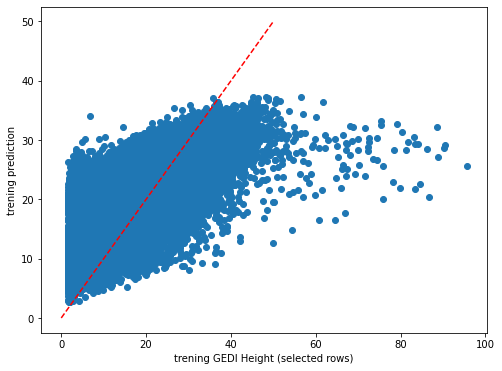

In [45]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('trening GEDI Height (selected rows)')
plt.ylabel('trening prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

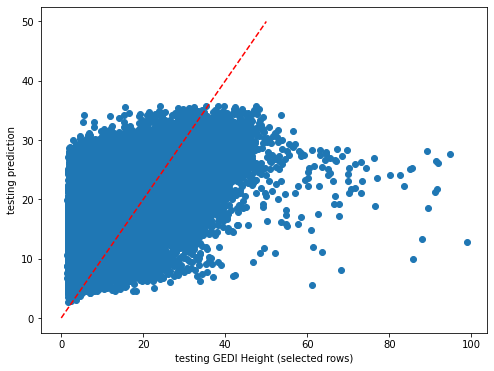

In [46]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('testing GEDI Height (selected rows)')
plt.ylabel('testing prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [47]:
impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)] 
ind = np.argsort(impt[0])

In [48]:
ind

array([ 1, 13,  0,  6,  4, 16,  5,  8,  2, 15,  3, 11, 12,  9, 14,  7, 10,
       17])

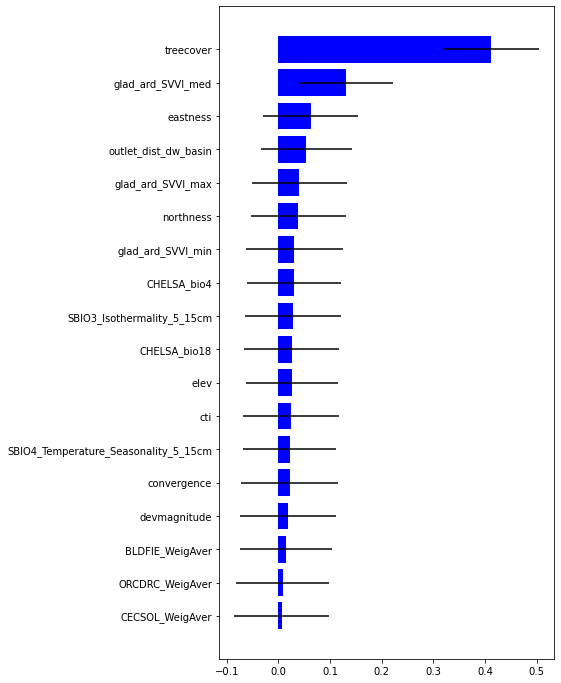

In [49]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

### Predict on the raster using pyspatialml (deprecated library)

In [49]:
# import Global Landsat Analysis Ready Data
glad_ard_SVVI_min = "tree_height/geodata_raster/glad_ard_SVVI_min.tif"
glad_ard_SVVI_med = "tree_height/geodata_raster/glad_ard_SVVI_med.tif"
glad_ard_SVVI_max = "tree_height/geodata_raster/glad_ard_SVVI_max.tif"

# import climate data
CHELSA_bio4 = "tree_height/geodata_raster/CHELSA_bio4.tif"
CHELSA_bio18 = "tree_height/geodata_raster/CHELSA_bio18.tif"

# import soil data
BLDFIE_WeigAver = "tree_height/geodata_raster/BLDFIE_WeigAver.tif"
CECSOL_WeigAver = "tree_height/geodata_raster/CECSOL_WeigAver.tif"
ORCDRC_WeigAver = "tree_height/geodata_raster/ORCDRC_WeigAver.tif"

# import geomorphological data (DEM derived)
elev = "tree_height/geodata_raster/elev.tif"
convergence = "tree_height/geodata_raster/convergence.tif"
northness = "tree_height/geodata_raster/northness.tif"
eastness = "tree_height/geodata_raster/eastness.tif"
devmagnitude = "tree_height/geodata_raster/dev-magnitude.tif"

# import hydrographic data (from hydrography90m)
cti = "tree_height/geodata_raster/cti.tif"
outlet_dist_dw_basin = "tree_height/geodata_raster/outlet_dist_dw_basin.tif"

# import soil climate data

SBIO3_Isothermality_5_15cm = "tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif"
SBIO4_Temperature_Seasonality_5_15cm = "tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif"

# import forest cover data

treecover = "tree_height/geodata_raster/treecover.tif"

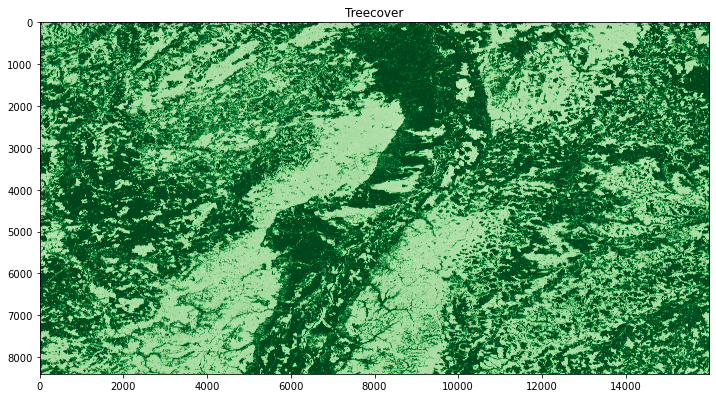

In [59]:
from matplotlib import pyplot as plt
src = rasterio.open("tree_height/geodata_raster/treecover.tif")
plt.figure(figsize=(12, 12))
plt.imshow(src.read(1), cmap='Greens')
plt.title("Treecover")
plt.show()


In [ ]:
predictors_rasters = [glad_ard_SVVI_min, glad_ard_SVVI_med, glad_ard_SVVI_max,
                      CHELSA_bio4,CHELSA_bio18,
                      BLDFIE_WeigAver,CECSOL_WeigAver,ORCDRC_WeigAver,
                      elev,convergence,northness,eastness,devmagnitude,cti,outlet_dist_dw_basin,
                      SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover]

stack = Raster(predictors_rasters)

In [60]:
result = stack.predict(estimator=rfReg, dtype='int16', nodata=-1)

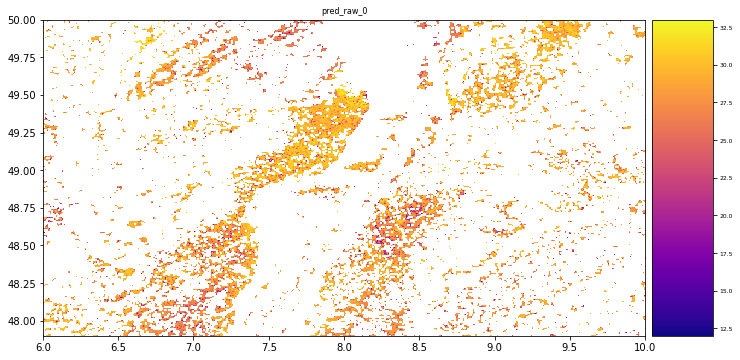

In [53]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()

### Predict on the raster using xarray and rasterio (Full size 90m res raster prediction >12h)

    import xarray as xr
    import rasterio
    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestRegressor
    import os
    
    # Define paths to raster files
    raster_paths = {
        'glad_ard_SVVI_min': "tree_height/geodata_raster/glad_ard_SVVI_min.tif",
        'glad_ard_SVVI_med': "tree_height/geodata_raster/glad_ard_SVVI_med.tif",
        'glad_ard_SVVI_max': "tree_height/geodata_raster/glad_ard_SVVI_max.tif",
        'CHELSA_bio4': "tree_height/geodata_raster/CHELSA_bio4.tif",
        'CHELSA_bio18': "tree_height/geodata_raster/CHELSA_bio18.tif",
        'BLDFIE_WeigAver': "tree_height/geodata_raster/BLDFIE_WeigAver.tif",
        'CECSOL_WeigAver': "tree_height/geodata_raster/CECSOL_WeigAver.tif",
        'ORCDRC_WeigAver': "tree_height/geodata_raster/ORCDRC_WeigAver.tif",
        'elev': "tree_height/geodata_raster/elev.tif",
        'convergence': "tree_height/geodata_raster/convergence.tif",
        'northness': "tree_height/geodata_raster/northness.tif",
        'eastness': "tree_height/geodata_raster/eastness.tif",
        'devmagnitude': "tree_height/geodata_raster/dev-magnitude.tif",
        'cti': "tree_height/geodata_raster/cti.tif",
        'outlet_dist_dw_basin': "tree_height/geodata_raster/outlet_dist_dw_basin.tif",
        'SBIO3_Isothermality_5_15cm': "tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif",
        'SBIO4_Temperature_Seasonality_5_15cm': "tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif",
        'treecover': "tree_height/geodata_raster/treecover.tif"
    }
    
    # Load raster files into an xarray Dataset
    raster_datasets = []
    for name, path in raster_paths.items():
        with rasterio.open(path) as src:
            # Read raster data and convert to xarray DataArray
            data = src.read(1)  # Read the first band
            coords = {
                'y': np.linspace(src.bounds.top, src.bounds.bottom, src.height),
                'x': np.linspace(src.bounds.left, src.bounds.right, src.width)
            }
            da = xr.DataArray(data, coords=coords, dims=['y', 'x'], name=name)
            raster_datasets.append(da)
    
    # Combine all DataArrays into a single Dataset
    stack = xr.merge(raster_datasets)
    
    # Prepare data for prediction
    # Convert the stack to a 2D array where each row is a pixel and columns are features
    feature_names = list(raster_paths.keys())
    data_array = stack.to_array(dim='variable').transpose('y', 'x', 'variable')
    data_2d = data_array.values.reshape(-1, len(feature_names))
    
    # Create a mask for valid data (exclude pixels where any predictor is NaN)
    valid_mask = ~np.any(np.isnan(data_2d), axis=1)
    valid_data = data_2d[valid_mask]
    
    # Predict tree heights for valid pixels using the trained RandomForestRegressor (rfReg)
    predictions = np.full(data_2d.shape[0], -1, dtype=np.int16)  # Initialize with nodata value
    predictions[valid_mask] = rfReg.predict(valid_data)
    
    # Reshape predictions back to the original raster shape
    pred_2d = predictions.reshape(data_array.shape[0], data_array.shape[1])
    
    # Save the prediction as a new raster file
    output_path = "tree_height/geodata_raster/predicted_tree_height.tif"
    with rasterio.open(
        list(raster_paths.values())[0],  # Use the first raster as a template for metadata
    ) as src:
        profile = src.profile
        profile.update(dtype=rasterio.int16, nodata=-1)
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(pred_2d, 1)
    
    # Plot the result using xarray
    ds_pred = xr.DataArray(pred_2d, coords={'y': stack.y, 'x': stack.x}, dims=['y', 'x'], name='predicted_height')
    ds_pred.plot(cmap='plasma', figsize=(12, 12))
    plt.title("Predicted Tree Height")
    plt.show()

### Predict on the raster using xarray and rasterio (1000x1000 UL corner tile for 90m res raster prediction)

In [50]:
# Define paths to raster files
raster_paths = {
    # import Global Landsat Analysis Ready Data
    'glad_ard_SVVI_min': "tree_height/geodata_raster/glad_ard_SVVI_min.tif", 
    'glad_ard_SVVI_med': "tree_height/geodata_raster/glad_ard_SVVI_med.tif",
    'glad_ard_SVVI_max': "tree_height/geodata_raster/glad_ard_SVVI_max.tif",
    # import climate data
    'CHELSA_bio4': "tree_height/geodata_raster/CHELSA_bio4.tif",
    'CHELSA_bio18': "tree_height/geodata_raster/CHELSA_bio18.tif",
    # import soil data
    'BLDFIE_WeigAver': "tree_height/geodata_raster/BLDFIE_WeigAver.tif",
    'CECSOL_WeigAver': "tree_height/geodata_raster/CECSOL_WeigAver.tif",
    'ORCDRC_WeigAver': "tree_height/geodata_raster/ORCDRC_WeigAver.tif",
    # import geomorphological data (DEM derived)
    'elev': "tree_height/geodata_raster/elev.tif",
    'convergence': "tree_height/geodata_raster/convergence.tif",
    'northness': "tree_height/geodata_raster/northness.tif",
    'eastness': "tree_height/geodata_raster/eastness.tif",
    'devmagnitude': "tree_height/geodata_raster/dev-magnitude.tif",
    # import hydrographic data (from hydrography90m)
    'cti': "tree_height/geodata_raster/cti.tif",
    'outlet_dist_dw_basin': "tree_height/geodata_raster/outlet_dist_dw_basin.tif",
    # import soil climate data
    'SBIO3_Isothermality_5_15cm': "tree_height/geodata_raster/SBIO3_Isothermality_5_15cm.tif",
    'SBIO4_Temperature_Seasonality_5_15cm': "tree_height/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif",
    # import forest cover data
    'treecover': "tree_height/geodata_raster/treecover.tif"
}

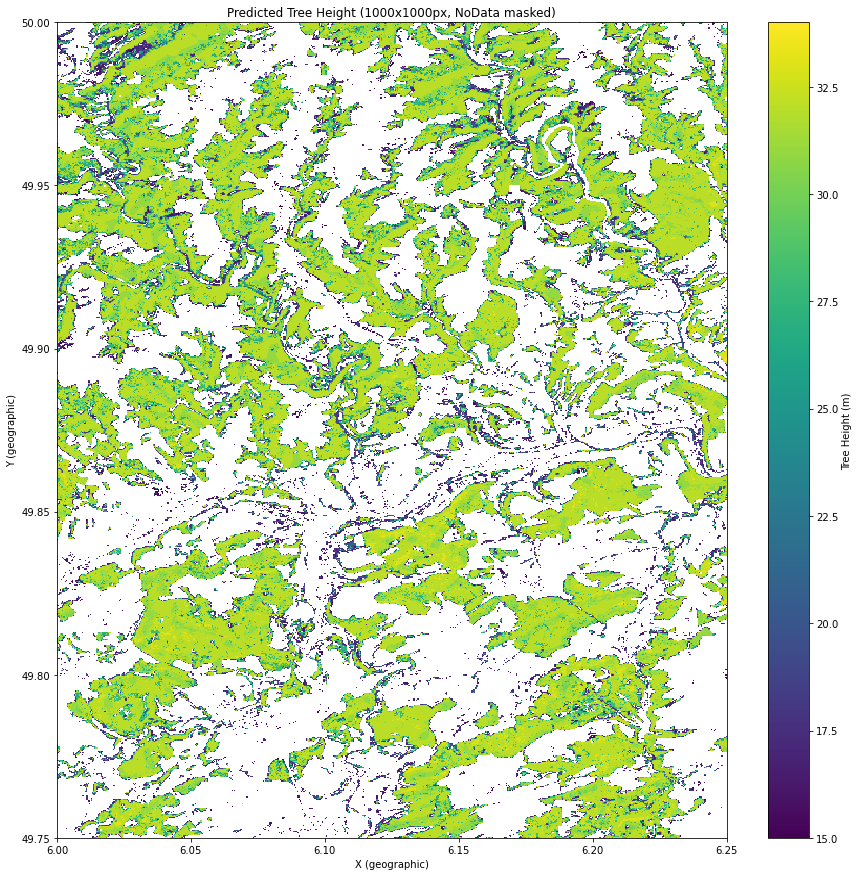

In [58]:
import xarray as xr
import rasterio
import rasterio.windows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Define a small window (1000x1000 UL corner) to avoid high time/computation demand
window = rasterio.windows.Window(0, 0, 1000, 1000)

# Load raster files into an xarray Dataset with NoData handling
raster_datasets = []
for name, path in raster_paths.items():
    with rasterio.open(path) as src:
        # Get NoData value from raster metadata
        nodata = src.nodata if src.nodata is not None else np.nan
        # Read data within the specified window
        data = src.read(1, window=window)
        
        # Replace raster-specific NoData values with np.nan for consistency
        if nodata is not np.nan:
            data = np.where(data == nodata, np.nan, data)
        
        # Transform coordinates for the window
        transform = src.window_transform(window)
        rows, cols = np.arange(window.height), np.arange(window.width)
        xs, ys = np.meshgrid(cols, rows)
        xs_geo, ys_geo = rasterio.transform.xy(transform, ys, xs)
        x_coords = np.array(xs_geo[0])  # X coordinates for columns
        y_coords = np.array([row[0] for row in ys_geo])  # Y coordinates for rows

        # Create xarray DataArray
        da = xr.DataArray(
            data,
            coords={'y': y_coords, 'x': x_coords},
            dims=['y', 'x'],
            name=name,
            attrs={'nodata': np.nan}  # Store NoData as NaN in attributes
        )
        raster_datasets.append(da)

# Combine all DataArrays into a single Dataset
stack = xr.merge(raster_datasets)

# Prepare data for prediction
# Convert the stack to a 2D array where each row is a pixel and columns are features
feature_names = list(raster_paths.keys())
data_array = stack.to_array(dim='variable').transpose('y', 'x', 'variable')
data_2d = data_array.values.reshape(-1, len(feature_names))

# Create a mask for valid data (exclude pixels where any predictor is NaN)
valid_mask = ~np.any(np.isnan(data_2d), axis=1)
valid_data = data_2d[valid_mask]

# Predict tree heights for valid pixels using the trained RandomForestRegressor
predictions = np.full(data_2d.shape[0], -1, dtype=np.int16)  # Initialize with NoData value (-1)
if valid_data.size > 0:  # Ensure there is valid data to predict
    predictions[valid_mask] = rfReg.predict(valid_data).astype(np.int16)
else:
    print("Warning: No valid data (non-NoData pixels) available for prediction.")

# Reshape predictions back to the original raster shape
pred_2d = predictions.reshape(data_array.shape[0], data_array.shape[1])

# Save the prediction as a new raster file
output_path = "tree_height/geodata_raster/predicted_tree_height_light.tif"
with rasterio.open(list(raster_paths.values())[0]) as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.int16,
        nodata=-1,  # Explicitly set NoData value
        width=window.width,
        height=window.height,
        transform=src.window_transform(window)
    )

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(pred_2d, 1)

# Plot the result using xarray with NoData masking
ds_pred = xr.DataArray(
    pred_2d,
    coords={'y': stack.y, 'x': stack.x},
    dims=['y', 'x'],
    name='predicted_tree_height',
    attrs={'nodata': -1}
)

# Mask NoData values (-1) for visualization
ds_pred_masked = ds_pred.where(ds_pred != -1)

# Plot with a colorbar and appropriate scaling for tree heights
plt.figure(figsize=(15, 15))
ds_pred_masked.plot(cmap='viridis', cbar_kwargs={'label': 'Tree Height (m)'})
plt.title("Predicted Tree Height (1000x1000px, NoData masked)")
plt.xlabel("X (geographic)")
plt.ylabel("Y (geographic)")
plt.show()